In [1]:
import os
output_folder = "/Users/Jayee/Library/CloudStorage/OneDrive-UW-Madison/\
PhD(my_PC)/PhD(output_files)/Engineering_projects/Shear_loading/240712_701_data/\
240713_neural_ode_701_upon_240712_applying_gpr_with_noise/finalised_NN_codes"


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
import time
import pickle

from sklearn.preprocessing import MinMaxScaler 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import torch.nn as nn
import torch.optim as optim

from scipy.interpolate import interp1d

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=30)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [3]:
## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

class ODEFuncVariance(nn.Module):

    def __init__(self):
        super(ODEFuncVariance, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcVariance = ODEFuncVariance().to(device)

class ODEFuncSkewness(nn.Module):

    def __init__(self):
        super(ODEFuncSkewness, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcSkewness = ODEFuncSkewness().to(device)
    
funcSkewness = ODEFuncSkewness().to(device)

class ODEFuncKurtosis(nn.Module):

    def __init__(self):
        super(ODEFuncKurtosis, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64,1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcKurtosis = ODEFuncKurtosis().to(device)

In [5]:
funcMeanLoaded = torch.load('0_mean_64_ReLU.pth')
funcSkwLoaded = torch.load('2_skewness_64_ReLU.pth')
funcVarLoaded = torch.load('1_variance.pth')
funcKurtLoaded = torch.load('3_kurtosis_64_ReLU.pth')

In [6]:

# Loading the imporant variables file.
file_name = "/Users/Jayee/Library/CloudStorage/OneDrive-UW-Madison/PhD(my_PC)/PhD(output_files)/\
Engineering_projects/Shear_loading/240712_701_data/240712_applying_GPR_with_noise/important_variables.pkl"
with open(file_name,"rb") as input_file:
    imp_vars = pickle.load(input_file)

# Uniform distance data
tmvsk = imp_vars["UDD"]

# Finding the derivative function as done in the NN case
## Central difference scheme
from scipy.interpolate import interp1d
xTrain = np.concatenate([tmvsk[:,1:],tmvsk[:,0].reshape(-1,1)],1)
tTrain = tmvsk[:,0]
gpr_m,gpr_v,gpr_s,gpr_k = [imp_vars["model"][_] for _ in range(4)]
timeStep = 2e-6

In [7]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

def combined_system(tVar, y):
    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])
    
    dm_dt =  funcMeanLoaded(tVar, y)
    
    dv_dt = funcVarLoaded(tVar, y)
   
    ds_dt = funcSkwLoaded(tVar, y)
       
    dk_dt = funcKurtLoaded(tVar, y)
       
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [8]:
# Initial state
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)
    
predicted_states=predicted_states.numpy()

In [9]:
mom_file_path = "/Users/Jayee/Library/CloudStorage/OneDrive-UW-Madison/PhD(Data)/\
shear_data/Von_mises_data/vm_701/moments_data/t_mvskm5m6_701.npy"
tmvsk = np.load(mom_file_path)

In [10]:
scaled_t_gt = imp_vars["t_scale"][0].transform(tmvsk[:,0].reshape(-1,1))
scaled_m_gt,scaled_v_gt,scaled_s_gt,scaled_k_gt = [imp_vars["m_scale"][_]
                                                   .transform(tmvsk[:,_+1].reshape(-1,1)) for _ in range(4)]
                                                   

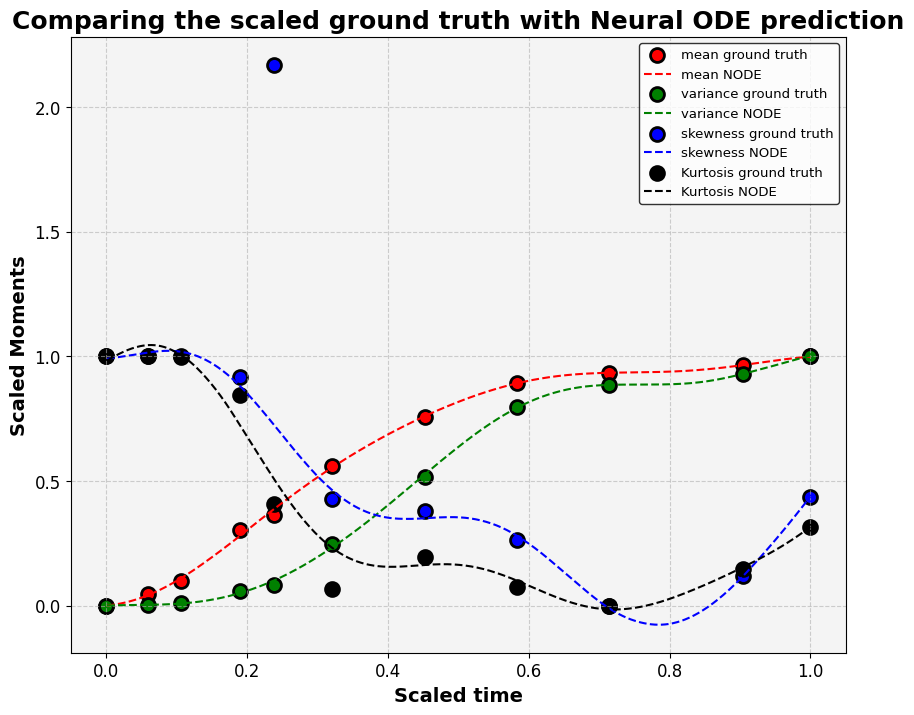

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(scaled_t_gt,scaled_m_gt, 
            c='r',s=100,edgecolor = "k",
            linewidth = 2,label='mean ground truth')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.scatter(scaled_t_gt,scaled_v_gt,  
            c='g',s=100,edgecolor = "k",
            linewidth = 2,label='variance ground truth')

plt.plot(tTrain,predicted_states[:,1], 'g--',label='variance NODE')

plt.scatter(scaled_t_gt,scaled_s_gt, 
            c='b',s=100,edgecolor = "k",
            linewidth = 2,label='skewness ground truth')
plt.plot(tTrain,predicted_states[:,2], 'b--',label='skewness NODE')

plt.scatter(scaled_t_gt,scaled_k_gt, 
            c='k',s=100,edgecolor = "k",
            linewidth = 2,label='Kurtosis ground truth')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Comparing the scaled ground truth with Neural ODE prediction", fontsize=18, fontweight='bold')
ax.set_xlabel("Scaled time", fontsize=14, fontweight='bold')
ax.set_ylabel("Scaled Moments", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='best', fontsize=9.5)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

# #Saving Figure
# file_name = "NN_prediction_with_all_scaled_ground_truth_skewness_64_ReLU.pdf"
# file_loc = os.path.join(output_folder,file_name)
# plt.savefig(file_loc, bbox_inches='tight')

# Show the plot
plt.show()


In [15]:
# removing 5th data in skewness and 6th data in kurtosis
scaled_t_gt_skew = np.delete(scaled_t_gt,4, axis = 0)
scaled_t_gt_Kurt = np.delete(scaled_t_gt,5, axis = 0)
scaled_s_gt_del =  np.delete(scaled_s_gt,4, axis = 0)
scaled_k_gt_del =  np.delete(scaled_k_gt,5, axis = 0)

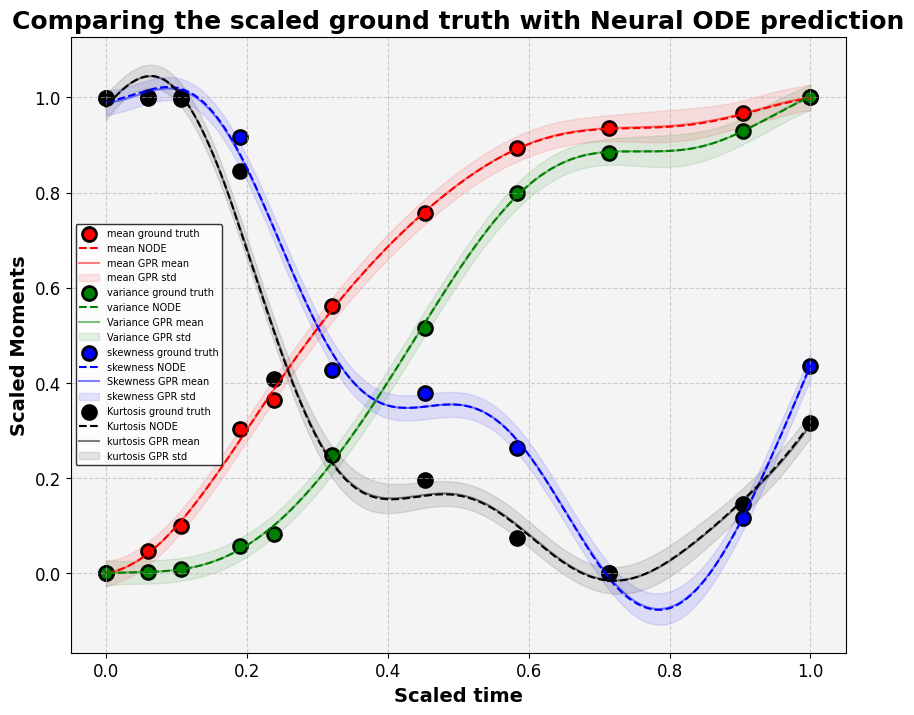

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(scaled_t_gt,scaled_m_gt, 
            c='r',s=100,edgecolor = "k",
            linewidth = 2,label='mean ground truth')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')
plt.plot(imp_vars["t_plot"],imp_vars["mean"][0], 'r-',alpha=0.5,label='mean GPR mean')
plt.fill_between(imp_vars["t_plot"],
                 imp_vars["mean"][0]+1.96*imp_vars["std"][0],
                 imp_vars["mean"][0]-1.96*imp_vars["std"][0],color="red",alpha=0.1,label='mean GPR std')

plt.scatter(scaled_t_gt,scaled_v_gt,  
            c='g',s=100,edgecolor = "k",
            linewidth = 2,label='variance ground truth')
plt.plot(tTrain,predicted_states[:,1], 'g--',label='variance NODE')
plt.plot(imp_vars["t_plot"],imp_vars["mean"][1], 'g-',alpha=0.5,label='Variance GPR mean')
plt.fill_between(imp_vars["t_plot"],
                 imp_vars["mean"][1]+1.96*imp_vars["std"][1],
                 imp_vars["mean"][1]-1.96*imp_vars["std"][1],color="green",alpha=0.1,label='Variance GPR std')

plt.scatter(scaled_t_gt_skew,scaled_s_gt_del, 
            c='b',s=100,edgecolor = "k",
            linewidth = 2,label='skewness ground truth')
plt.plot(tTrain,predicted_states[:,2], 'b--',label='skewness NODE')
plt.plot(imp_vars["t_plot"],imp_vars["mean"][2], 'b-',alpha=0.5,label='Skewness GPR mean')
plt.fill_between(imp_vars["t_plot"],
                 imp_vars["mean"][2]+1.96*imp_vars["std"][2],
                 imp_vars["mean"][2]-1.96*imp_vars["std"][2],color="blue",alpha=0.1,label='skewness GPR std')

plt.scatter(scaled_t_gt_Kurt,scaled_k_gt_del, 
            c='k',s=100,edgecolor = "k",
            linewidth = 2,label='Kurtosis ground truth')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')
plt.plot(imp_vars["t_plot"],imp_vars["mean"][3], 'k-',alpha=0.5,label='kurtosis GPR mean')
plt.fill_between(imp_vars["t_plot"],
                 imp_vars["mean"][3]+1.96*imp_vars["std"][3],
                 imp_vars["mean"][3]-1.96*imp_vars["std"][3],color="black",alpha=0.1,label='kurtosis GPR std')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Comparing the scaled ground truth with Neural ODE prediction", fontsize=18, fontweight='bold')
ax.set_xlabel("Scaled time", fontsize=14, fontweight='bold')
ax.set_ylabel("Scaled Moments", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='best', fontsize=7)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

# file_name = "NN_prediction_with_deleted_scaled_ground_truth_and_GPR_curves_skewness_64_ReLU.pdf"
# file_loc = os.path.join(output_folder,file_name)
# plt.savefig(file_loc, bbox_inches='tight')


# Show the plot
plt.show()


## Let us see how the neural networks behave at different initial conditions.



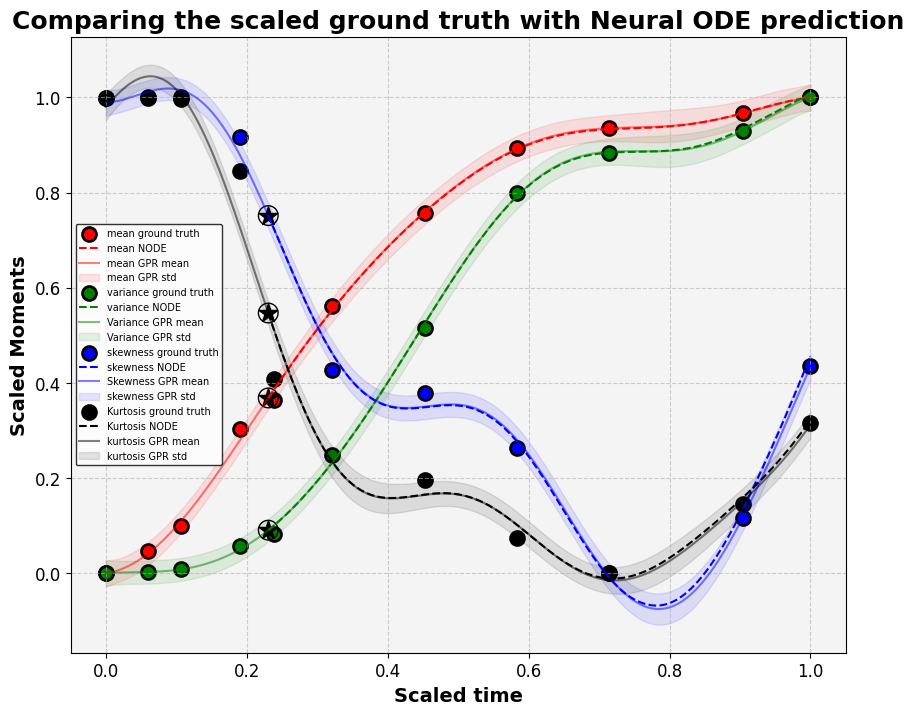

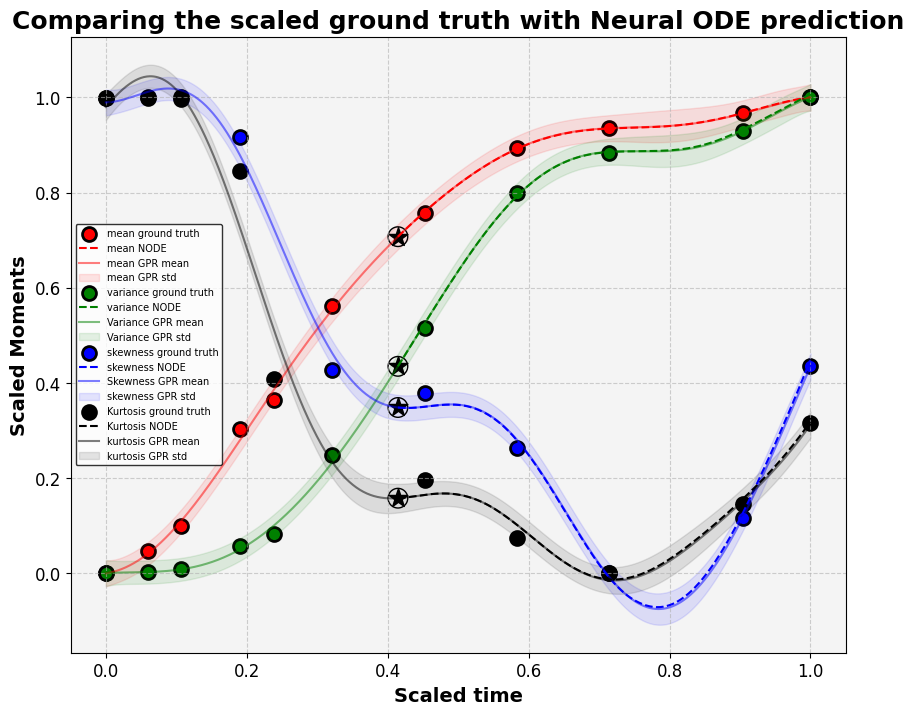

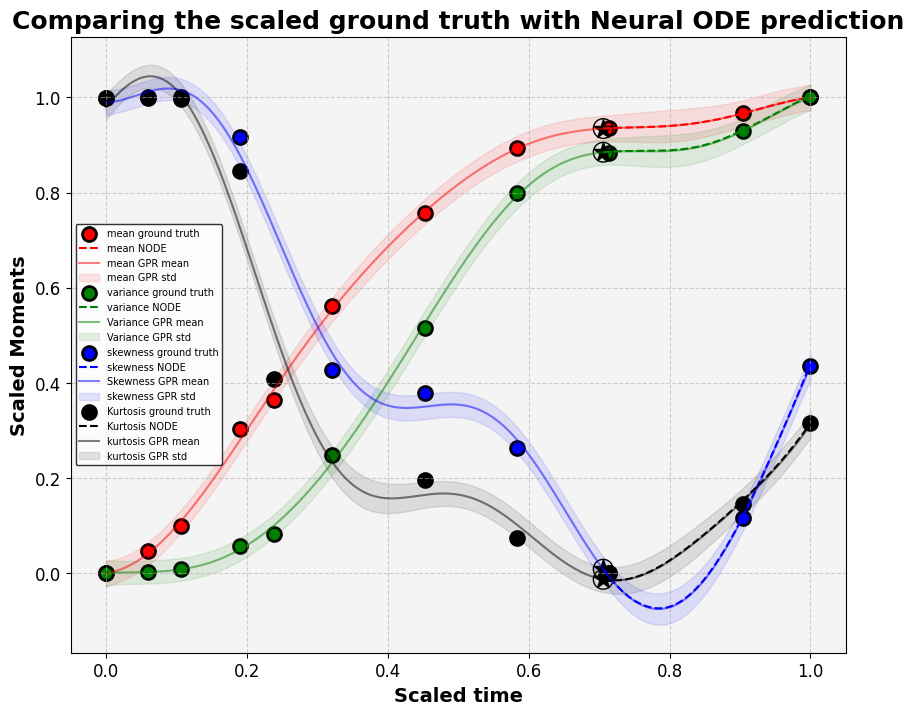

In [87]:
for index in [250,500,750]:
    y0 = torch.squeeze(true_y[index])

    # Time point for prediction
    tTrain = t[index:]
    with torch.no_grad():
        predicted_states = odeint(combined_system,y0 , t[index:]).to(device)

    predicted_states=predicted_states.numpy()
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.scatter(scaled_t_gt,scaled_m_gt, 
                c='r',s=100,edgecolor = "k",
                linewidth = 2,label='mean ground truth')
    plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')
    plt.plot(imp_vars["t_plot"],imp_vars["mean"][0], 'r-',alpha=0.5,label='mean GPR mean')
    plt.fill_between(imp_vars["t_plot"],
                     imp_vars["mean"][0]+1.96*imp_vars["std"][0],
                     imp_vars["mean"][0]-1.96*imp_vars["std"][0],color="red",alpha=0.1,label='mean GPR std')

    plt.scatter(scaled_t_gt,scaled_v_gt,  
                c='g',s=100,edgecolor = "k",
                linewidth = 2,label='variance ground truth')
    plt.plot(tTrain,predicted_states[:,1], 'g--',label='variance NODE')
    plt.plot(imp_vars["t_plot"],imp_vars["mean"][1], 'g-',alpha=0.5,label='Variance GPR mean')
    plt.fill_between(imp_vars["t_plot"],
                     imp_vars["mean"][1]+1.96*imp_vars["std"][1],
                     imp_vars["mean"][1]-1.96*imp_vars["std"][1],color="green",alpha=0.1,label='Variance GPR std')

    plt.scatter(scaled_t_gt_skew,scaled_s_gt_del, 
                c='b',s=100,edgecolor = "k",
                linewidth = 2,label='skewness ground truth')
    plt.plot(tTrain,predicted_states[:,2], 'b--',label='skewness NODE')
    plt.plot(imp_vars["t_plot"],imp_vars["mean"][2], 'b-',alpha=0.5,label='Skewness GPR mean')
    plt.fill_between(imp_vars["t_plot"],
                     imp_vars["mean"][2]+1.96*imp_vars["std"][2],
                     imp_vars["mean"][2]-1.96*imp_vars["std"][2],color="blue",alpha=0.1,label='skewness GPR std')

    plt.scatter(scaled_t_gt_Kurt,scaled_k_gt_del, 
                c='k',s=100,edgecolor = "k",
                linewidth = 2,label='Kurtosis ground truth')
    plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')
    plt.plot(imp_vars["t_plot"],imp_vars["mean"][3], 'k-',alpha=0.5,label='kurtosis GPR mean')
    plt.fill_between(imp_vars["t_plot"],
                     imp_vars["mean"][3]+1.96*imp_vars["std"][3],
                     imp_vars["mean"][3]-1.96*imp_vars["std"][3],color="black",alpha=0.1,label='kurtosis GPR std')

    for _ in range(4):
        plt.scatter(tTrain[0].item(),y0[_].item(),marker='*',s=200,facecolors='k',edgecolors='black')
        plt.scatter(tTrain[0].item(),y0[_].item(),marker='o',s=200,facecolors='none',edgecolors='black')

    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    # Customize fonts and sizes
    ax.set_title("Comparing the scaled ground truth with Neural ODE prediction", fontsize=18, fontweight='bold')
    ax.set_xlabel("Scaled time", fontsize=14, fontweight='bold')
    ax.set_ylabel("Scaled Moments", fontsize=14, fontweight='bold')

    # Increase tick label font size
    ax.tick_params(axis='both', labelsize=12)

    # Customize the appearance of the legend
    legend = ax.legend(loc='best', fontsize=7)
    legend.get_frame().set_edgecolor('black')
    ax.set_facecolor('#F4F4F4')

    # Saving the plots
    file_name = f"NN_prediction_with_deleted_scaled_ground_truth_and_GPR_curves_skewness_64_ReLU_{index}.pdf"
    file_loc = os.path.join(output_folder,file_name)
    plt.savefig(file_loc, bbox_inches='tight')


    # Show the plot
    plt.show()
